# Analyzing the Road Accidents Data In Kenay for the Years 2016 and 2017 
## The libraries needed 

In [28]:
using DataFrames
using XLSX
using FloatingTableView
using Dates
using Plots
using HypothesisTests
using Distributions
using VegaLite
include("libraries.jl")

# Read in the Data

In [31]:
roadData2016 = DataFrame(XLSX.readtable("kenya-accidents-database.xlsx","2016",infer_eltypes=true))
roadData2017 = DataFrame(XLSX.readtable("kenya-accidents-database.xlsx","2017",infer_eltypes=true))


,TIME 24 HOURS,BASE/SUB BASE,COUNTY,ROAD,PLACE
,Any,String?,String?,String?,String?
1,745,KISUMU,KISUMU,NAIROBI-BUSIA,KASAGAM FLY OVER
2,1430,NAROK,NAROK,NAROK-MAU,NAROK TOWN
3,1515,LONDIANI,KERICHO,KERICHO-NAKURU,JUBERT AREA
4,1600,KIMILILI,BUNGOMA,BOKOLI-KIMILILI,BITUYU AREA
5,1747,NAKURU,NAKURU,PIPELINE ELEMENTAITA,PIPELINE AREA
6,1830,ONGATA RONGAI,KAJIADO,MAGADI ROAD,CHAPCHAP AREA
7,1745,NAKURU,NAKURU,LANET-NDUNDORI,KAREMENU CENTER
8,2030,LONDIANI,KERICHO,LONDIANI-KERICHO,CHEBOWOR AREA
9,2300,KERICHO,KERICHO,NAKURU-KERICHO,DUKA MOJA AREA


# Data Cleaning 

In [32]:
# 1.) Unify the column names to be able to merge the data 
cols1 = names(roadData2016)
cols2 = names(roadData2017)

diffCols = cols2[cols2 .∉ Ref(cols1)]
upDateRoadData2017 = select(roadData2017,Not(diffCols))
finalRoadData = vcat(roadData2016,upDateRoadData2017)

# 2.) Check the data types to be correct and drop all missing values
eltype.(eachcol(finalRoadData))
filter(ismissing,finalRoadData[:,Symbol("TIME 24 HOURS")])  
finalRoadData = dropmissing(finalRoadData) 

,TIME 24 HOURS,BASE/SUB BASE,COUNTY,ROAD,PLACE
,Any,String,String,String,String
1,630,KITUI,MAKUENI,KITUI-ITHOKWE,KITUI SCHOOL
2,830,VOI,TAITA TAVETA,MOMBASA-NAIROBI,IKANGA
3,1330,MARIAKANI,KILIFI,MOMBASA-NAIROBI,KATOLANI
4,2100,ONGATA RONGAI,NAKURU,NAKURU-NAIROBI,MAASAI LODGE
5,1900,MATUU,MACHAKOS,MATUU-MWINGI,KIVANDINI
6,2130,NYANDO,HOMA BAY,KATITO-KENDU BAY,PAP ONDITI
7,1200,MWEA,KIRINYAGA,MAKUTANO-MWEA,MUMATI AREA
8,1330,NAKURU,NAKURU,KENYATTA AVENUE,NEAR OILIBIA
9,1930,KAYOLE,NAIROBI,EASTERN BY PASS,NEAR GULF PETROL STATION


In [34]:
# 3.) Clean up time column and convert it to julia's type Time

"""
a.) conversion function to time
"""
toTimeConverter(x::Integer) = Time(divrem(x, 100)...)

"""
b.)Remove String/Characters in the time col
"""

function removeUnwantedChar(input::Any)
    reducedStr = 
        if length(input) > 4
            deleteat!(collect(input),5:length(input)) |> String
        elseif occursin("H",string(input))
            idx = findfirst("H",input)
            deleteat!(collect(input),idx) |> String
        else
           input
        end
      return reducedStr
end
  

finalRoadData[!,Symbol("TIME 24 HOURS")]  = ifelse.(finalRoadData[:,Symbol("TIME 24 HOURS")] .== "UNKNOWN TIME", "0000", finalRoadData[:,Symbol("TIME 24 HOURS")])
finalRoadData[!,Symbol("TIME 24 HOURS")]  = ifelse.(finalRoadData[:,Symbol("TIME 24 HOURS")] .== "UNKNOWN", "0000", finalRoadData[:,Symbol("TIME 24 HOURS")])
finalRoadData[!,Symbol("TIME 24 HOURS")]  = removeUnwantedChar.(finalRoadData[!,Symbol("TIME 24 HOURS")])
finalRoadData[!,Symbol("TIME 24 HOURS")] = [x isa AbstractString ? parse(Int, x) : Int(x) for x in finalRoadData[!,:1]]
finalRoadData[!,Symbol("TIME 24 HOURS")] = toTimeConverter.(finalRoadData[:,:1]) 

1068-element Vector{Time}:
 06:30:00
 08:30:00
 13:30:00
 21:00:00
 19:00:00
 21:30:00
 12:00:00
 13:30:00
 19:30:00
 20:30:00
 ⋮
 20:30:00
 08:45:00
 09:30:00
 12:50:00
 17:30:00
 19:30:00
 21:45:00
 20:39:00
 01:39:00

In [35]:
#4.) Renaming the columns to better names 
newColNames = [:Time,:subCounty,:County,:Road,:Place,:Details,:Gender,:Age,:CauseCode,:Victim,:Number,:Date]
finalRoadData = rename(finalRoadData,names(finalRoadData) .=> newColNames)

,Time,subCounty,County,Road,Place
,Time,String,String,String,String
1,06:30:00,KITUI,MAKUENI,KITUI-ITHOKWE,KITUI SCHOOL
2,08:30:00,VOI,TAITA TAVETA,MOMBASA-NAIROBI,IKANGA
3,13:30:00,MARIAKANI,KILIFI,MOMBASA-NAIROBI,KATOLANI
4,21:00:00,ONGATA RONGAI,NAKURU,NAKURU-NAIROBI,MAASAI LODGE
5,19:00:00,MATUU,MACHAKOS,MATUU-MWINGI,KIVANDINI
6,21:30:00,NYANDO,HOMA BAY,KATITO-KENDU BAY,PAP ONDITI
7,12:00:00,MWEA,KIRINYAGA,MAKUTANO-MWEA,MUMATI AREA
8,13:30:00,NAKURU,NAKURU,KENYATTA AVENUE,NEAR OILIBIA
9,19:30:00,KAYOLE,NAIROBI,EASTERN BY PASS,NEAR GULF PETROL STATION


# Data Crunching
## 1.) analyze accidents by time of occurance

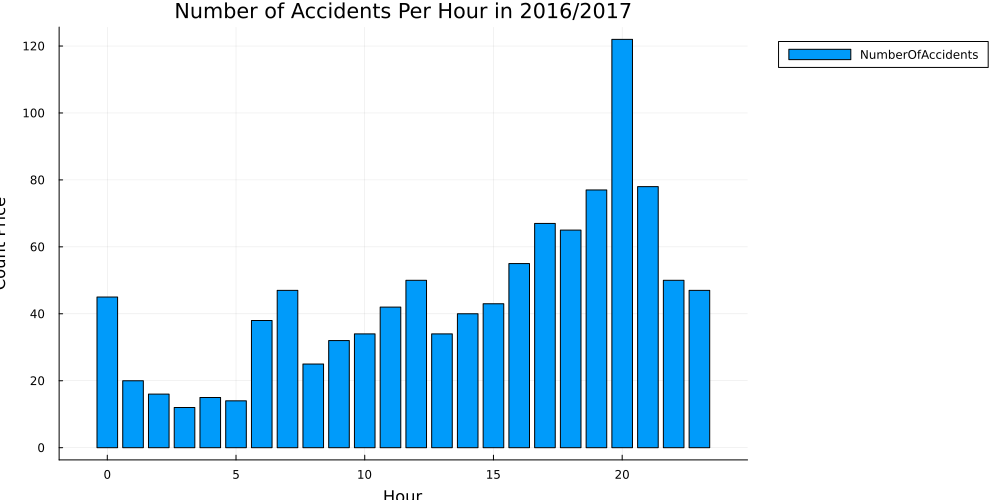

In [36]:
# a.) analyze by Hour 
accidentByHour = 
         finalRoadData |> 
         finalRoadData -> combine(groupby(transform(finalRoadData,[:Time,:Date] .=> [ByRow(hour),ByRow(year)]),
                                  [:Time_hour]),:Time_hour .=> length => :accidentsByHour) 
               

Plots.bar(accidentByHour[:,:Time_hour],
        accidentByHour[:,:accidentsByHour],
        title  = "Number of Accidents Per Hour in 2016/2017",
        xlabel = "Hour",
        ylabel = "Count Price",
        label="NumberOfAccidents",
        size = (1000,500),
        legend = :outertopright)


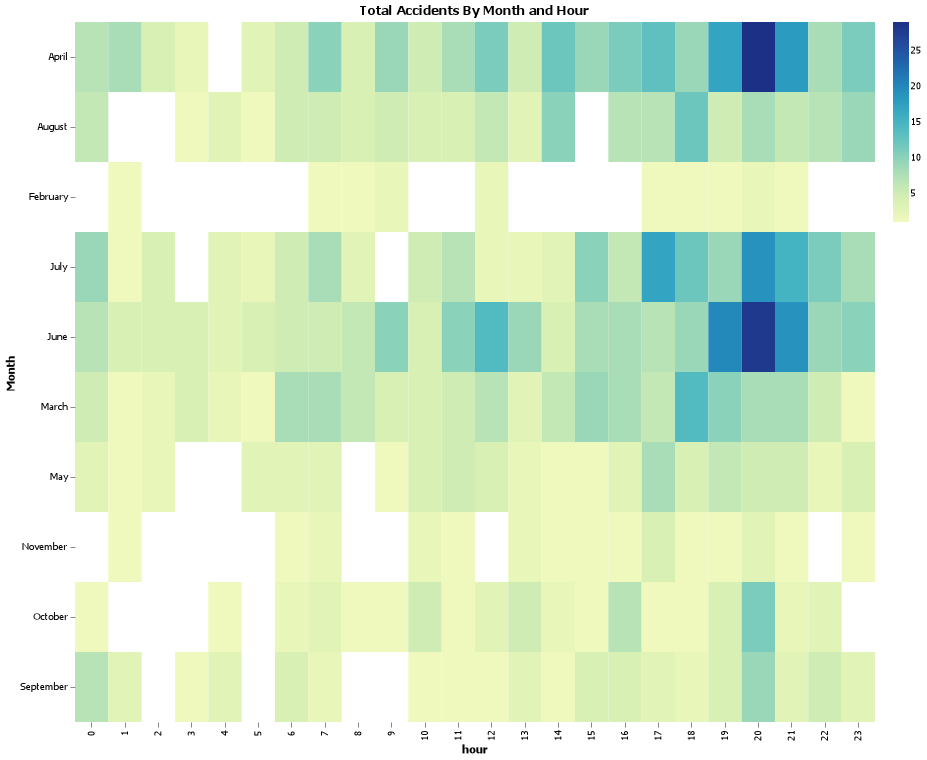

In [37]:
# b.) Analyze by Month
accidentsByMonth = 
        finalRoadData |> 
        finalRoadData -> combine(groupby(transform(finalRoadData,[:Date,:Time] .=> [ByRow(month),ByRow(hour)]),
                         [:Date_month,:Time_hour]),:Date_month .=> length => :monthlyHourlyAccidents)                     

data2 = accidentsByMonth[:,:1]
df2 = DataFrame(map(idx -> getindex.(data2, idx), eachindex(first(data2))),:auto)
df2.date = map(x-> Date.(Month(x)), df2.x1)
df2.month = map(y-> Dates.monthname.(Date.(Month(y))), df2.x1) 
cleanMonthlyData = hcat(df2[:,[:3]],accidentsByMonth[:,:2:end])

cleanMonthlyData |>
    @vlplot(
        title="Total Accidents By Month and Hour",
        :rect,
        x={
            "Time_hour:o",            
            title="hour",            
        },
        y={
            "month:o",          
            title="Month"
        },width=800,height=700,
        color={
            "monthlyHourlyAccidents:q",
            aggregate="sum",
            legend={title=nothing}
        },
        config={
            view={
                strokeWidth=0,
                step=13
            },
            axis={
                domain=false
            }
        }
    )


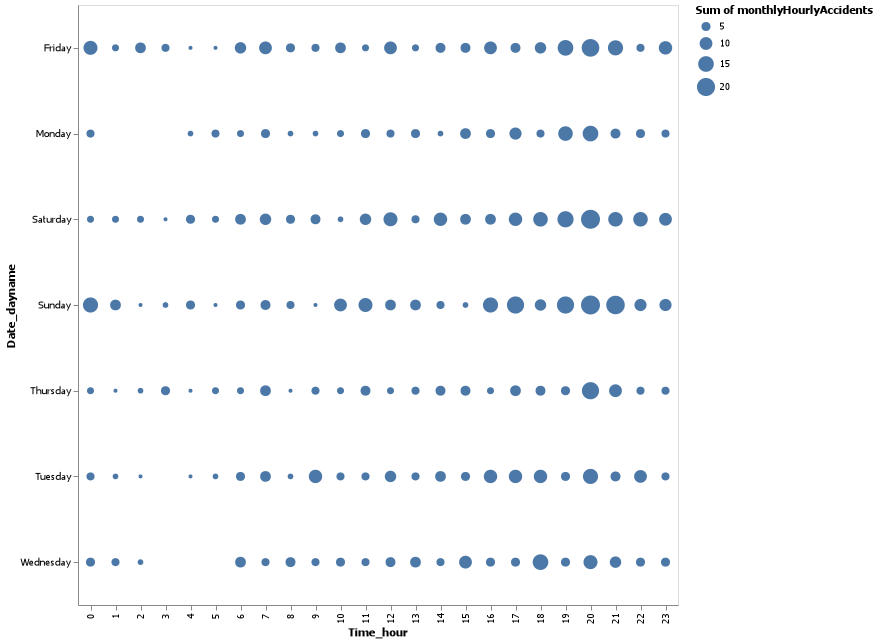

In [38]:
# c.) Analyze by Day and Hour
accidentsByDayAndHr = 
        finalRoadData |> 
        finalRoadData -> combine(groupby(transform(finalRoadData,[:Date,:Time] .=> [ByRow(dayname),ByRow(hour)]),
                         [:Date_dayname,:Time_hour]),:Date_dayname .=> length => :monthlyHourlyAccidents)

accidentsByDayAndHr |>
    @vlplot(
        :circle,
        y="Date_dayname:o",
        x="Time_hour:o",
        size="sum(monthlyHourlyAccidents)",
        width=600,height=600
    )

# Statistical Test 

## conduct the kruskal wallis test This is done to test for seasonality 

### H₀ : The distribution of the nummber of accidents are the same for each hour of the day(i.e the time of the day does not affect the number of accidents) 
### H₁ : There are hours during the day for which the distribution of the number of accidents differ significatly



In [39]:
grps = accidentByHour[:,:Time_hour]
values = accidentByHour[:,:accidentsByHour]
kWallisRes = KruskalWallisTest(grps,values)

Kruskal-Wallis rank sum test (chi-square approximation)
-------------------------------------------------------
Population details:
    parameter of interest:   Location parameters
    value under h_0:         "all equal"
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-06

Details:
    number of observation in each group: [24, 24]
    χ²-statistic:                        26.0556
    rank sums:                           [340.5, 835.5]
    degrees of freedom:                  1
    adjustment for ties:                 0.999566


# 2.) Analyze the Number of accidents by County and Sub County

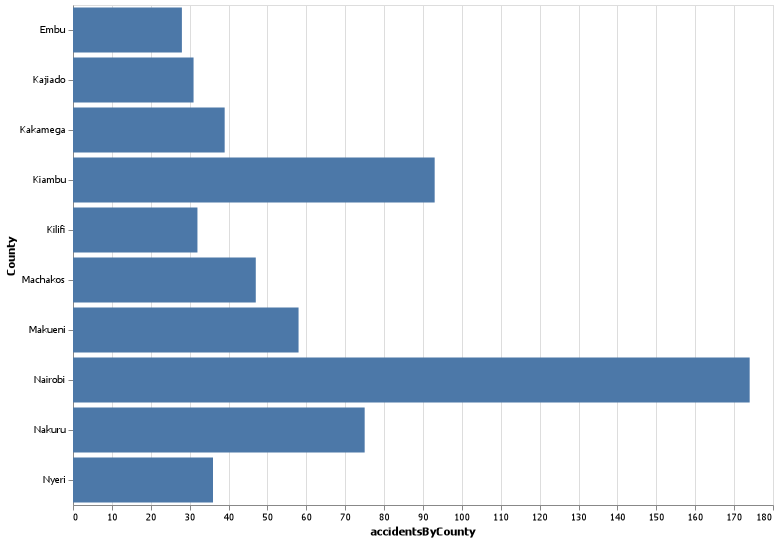

In [40]:
#a.)Analysis by county 
finalRoadData[!,:County] = lowercase.(finalRoadData[!,:County]) |> x -> uppercasefirst.(x)

noOfAccidentsByCounty = 
    finalRoadData |>
    finalRoadData -> combine(groupby(finalRoadData,:County),:County .=> length .=> :accidentsByCounty) |>
    finalRoadData -> sort(finalRoadData,:2,rev = true) |>
    finalRoadData -> first(finalRoadData,10)

noOfAccidentsByCounty |> @vlplot(:bar,y=:County,x=:accidentsByCounty,width=700,height=500)


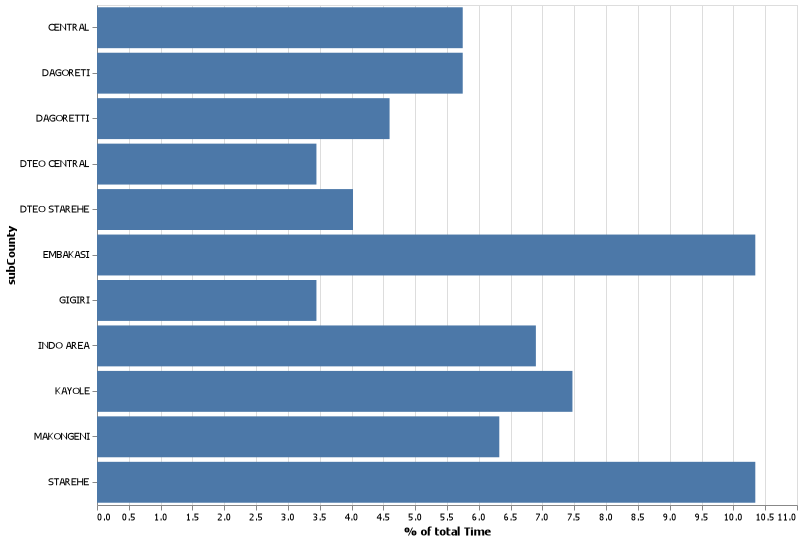

In [41]:
#b.) Analysis by SubCounty

accidentsBySubCounty = 
    finalRoadData |>
    finalRoadData -> filter(:County => ==("Nairobi"),finalRoadData)|>
    finalRoadData -> combine(groupby(finalRoadData,:2),:2 .=> length => :accidentsBySubCounty) |>
    finalRoadData -> sort(finalRoadData,:2,rev = true) 
    
accidentsBySubCounty |>
    @vlplot(
        height={step=12},
        :bar,
        transform=[
            {
                window=[{op="sum",field="accidentsBySubCounty",as="totalAcidents"}],
                frame=[nothing,nothing]
            },
            {
                calculate="datum.accidentsBySubCounty/datum.totalAcidents * 100",
                as="PercentOfTotal"
            },
            {
            window=[{ op="rank", as="rank" }],
            sort=[{ field="accidentsBySubCounty", order="descending" }]
            },
             {filter="datum.rank <= 10"}
        ],
        x={"PercentOfTotal:q", axis={title="% of total Time"}},
        y={"subCounty:n"},
        width=700,height=500
    )


WARN Symbol legend count exceeds limit, filtering items.
WARN Symbol legend count exceeds limit, filtering items.


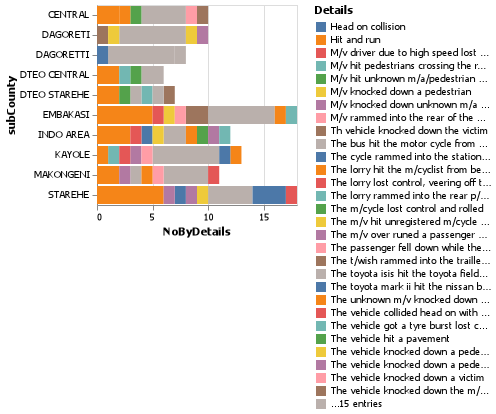

In [44]:
# c.) Narrow Down to details i.e cause of the accidents in the various sub county 

finalRoadData[!,:Details] = replace.(finalRoadData[:,:Details], "&" .=> "AND")
finalRoadData[!,:Details] = replace.(finalRoadData[:,:Details], "HIT AND RAN" .=> "HIT AND RUN")
finalRoadData[!,:Details] = lowercase.(finalRoadData[!,:Details]) |> x -> uppercasefirst.(x)

selectedSubCounties = first(accidentsBySubCounty,10) |> local data -> data[:,:subCounty]

noOfAccidentsByDetails = 
    finalRoadData |>
    finalRoadData -> filter(:County => ==("Nairobi"),finalRoadData)|>
    finalRoadData -> filter(x -> x.subCounty in selectedSubCounties, finalRoadData) |>
    finalRoadData -> combine(groupby(finalRoadData,[:subCounty,:Details]),:Details .=> length .=> :NoByDetails) |>
    finalRoadData -> sort(finalRoadData,[:1,:3],rev =[true,true]) 
    #finalRoadData -> first(finalRoadData,20)

noOfAccidentsByDetails |>
    @vlplot(:bar, x="NoByDetails", y=:subCounty, color=:Details)


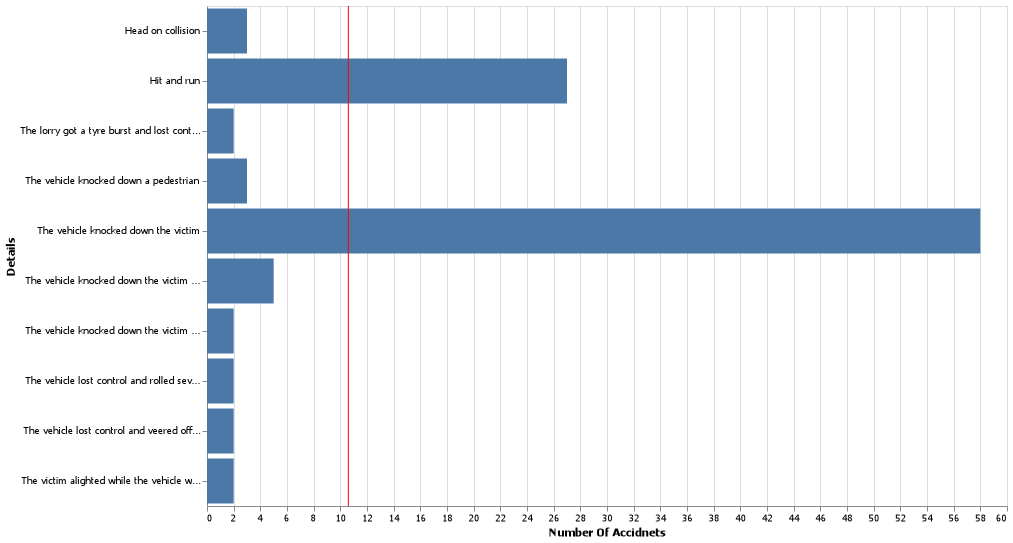

In [45]:
# d.) By County and Details Focusing on the average number of accidents by details
countyAndDetails = 
    finalRoadData |>
    finalRoadData -> filter(:County => ==("Nairobi"),finalRoadData)|>
    finalRoadData -> combine(groupby(finalRoadData,:Details),:Details .=> length .=> :ByDetails) |>
    finalRoadData -> sort(finalRoadData,:2,rev = true) |>
    finalRoadData -> first(finalRoadData,10) 

countyAndDetails |>
    @vlplot(
        transform=[
            {filter="datum.ByDetails != null"},
            {
                joinaggregate= [{
                    op=:mean,
                    field=:ByDetails,
                    as="AverageAccidents"
                }]
            }           
        ]
    ) +
    @vlplot(
        :bar,
        x={"ByDetails:q",axis={title="Number Of Accidnets"}},width=800,height=500,
        y={"Details:o"}
    ) +
    @vlplot(
        mark={
            :rule,
            color="red"
        },
        x={"AverageAccidents:q", aggregate="average"}
    )



# 4.) Analyze the Number of accidents by Road

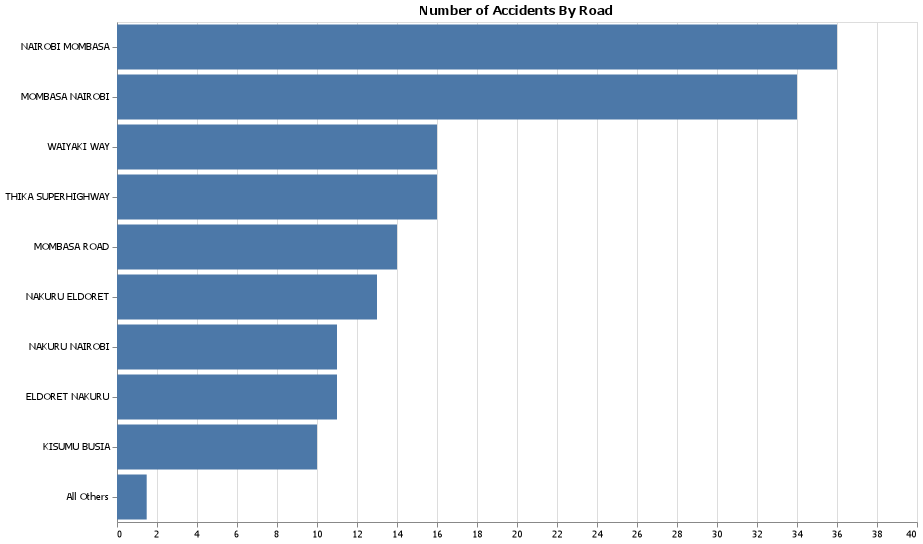

In [46]:
#a.) by Road count
finalRoadData[!,:Road] = replace.(finalRoadData[!,:Road], "-" .=> " ", count=1)

noOfAccidentsByRoad = 
    finalRoadData |>
    finalRoadData -> combine(groupby(finalRoadData,:Road),:Road .=> length .=> :accidentsByRoad) |>
    finalRoadData -> sort(finalRoadData,:2,rev = true)
   

noOfAccidentsByRoad |>
    @vlplot(
        title="Number of Accidents By Road",
        transform=[
            {
                aggregate=[{op="mean",field="accidentsByRoad",as="aggregate_accidents"}],
                groupby=["Road"]
            },
            {
                window=[{op="row_number", as="rank"}],
                sort=[{field="aggregate_accidents",order="descending"}]
            },
            {
                calculate="datum.rank < 10 ? datum.Road : 'All Others'", as="ranked_ByRoad"
            }
        ],
        :bar,
        x={aggregate="mean","aggregate_accidents:q",title=nothing},width=800,height=500,
        y={
            sort={op="mean",field="aggregate_accidents",order="descending"},
            "ranked_ByRoad:o",
            title=nothing
        }
    )


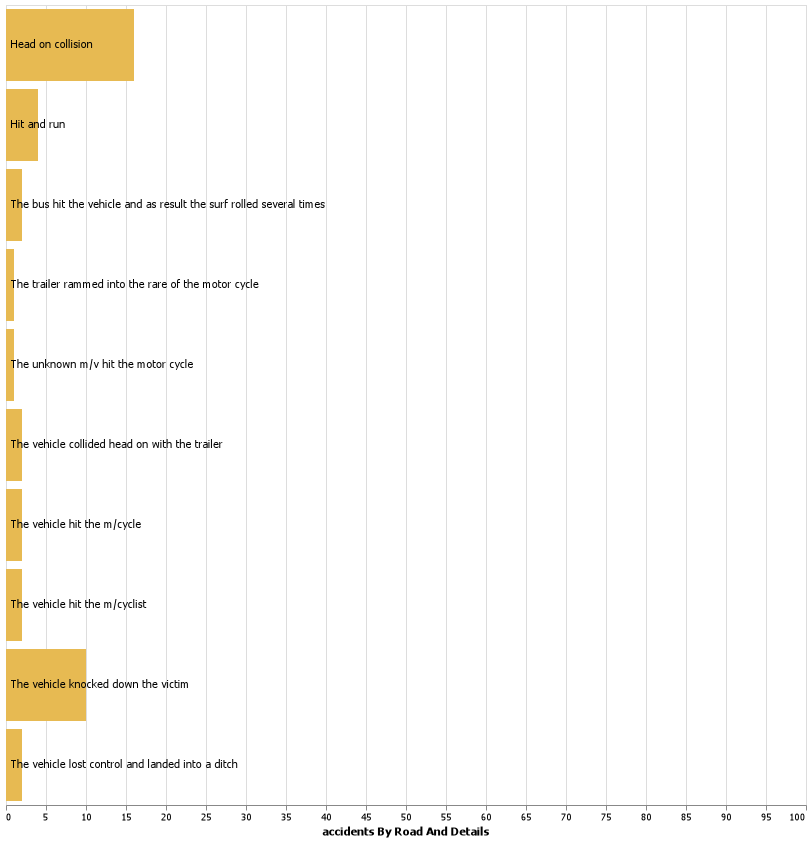

In [47]:
# b.) By Road and details
noOfAccidentsByRoadAndDetail = 
    finalRoadData |>
    finalRoadData -> filter(:Road => in(Set(["NAIROBI MOMBASA","MOMBASA NAIROBI"])),finalRoadData)|>
    finalRoadData -> combine(groupby(finalRoadData,[:Details]),:Details => length .=> :accidentsByRoadAndDetails) |>
    finalRoadData -> sort(finalRoadData,:2,rev = true)|>
    finalRoadData -> first(finalRoadData,10)
    
noOfAccidentsByRoadAndDetail |>
    @vlplot(
        width=200,
        height={step=16},
        y={:Details,axis=nothing},width=800,height=800
    ) +
    @vlplot(
        mark={:bar,color="#e7ba52"},
        x={"accidentsByRoadAndDetails",axis={title="accidents By Road And Details"},scale={domain=[0,100]}},           
    ) +
    @vlplot(
        mark={:text,align="left",x=5},
        text="Details:n"
        #detail={aggregate="count",type="quantitative"}
    )


# 5.) Anyze the Number of occurences by the Victims

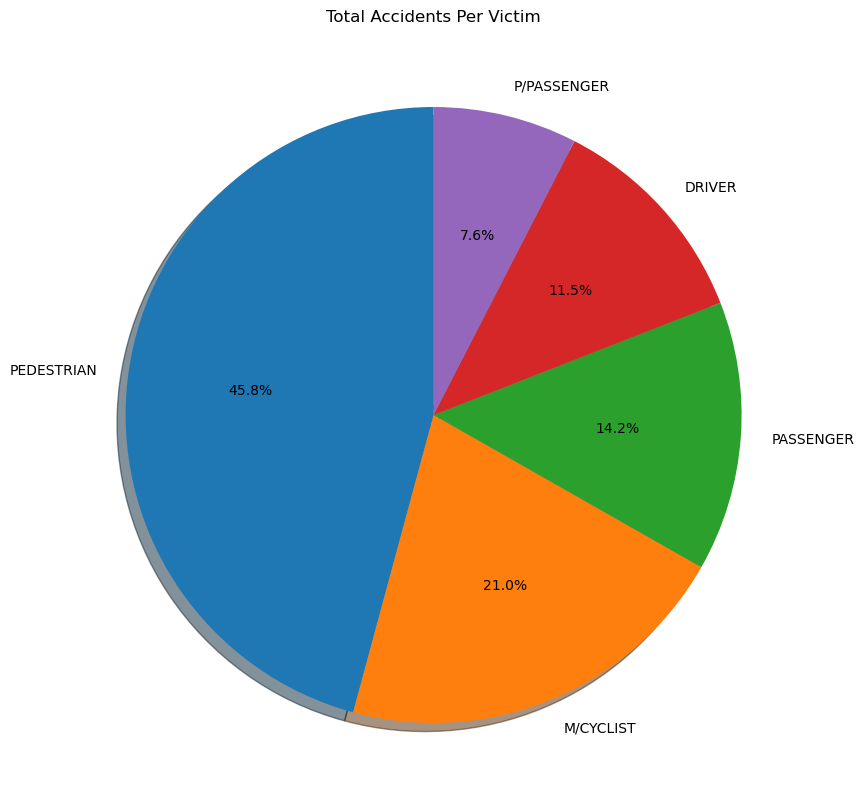

In [49]:
noOfAccidentsByVictim = 
    finalRoadData |>
    finalRoadData -> combine(groupby(finalRoadData,:Victim),:Victim .=> length .=> :accidentsByVictims) |>
    finalRoadData -> sort(finalRoadData,:2,rev = true) |>
    finalRoadData -> first(finalRoadData,5)

labels = noOfAccidentsByVictim[:,:Victim]
noOfAccidentsPerVictim = noOfAccidentsByVictim[:,:accidentsByVictims]

###############
p = PyPlot.pie(noOfAccidentsPerVictim,
                labels=labels,
                shadow=true,
                startangle=90,
                autopct="%1.1f%%")		
title("Total Accidents Per Victim")
figure("pyplot_piechart",figsize=(10,10))


# 6.) Anzye By the Age Group and Gender

In [50]:
map(eachrow(finalRoadData)) do r
    if r.Gender .== "M" 
       r.Gender = 1
    elseif r.Gender .== "F"
           r.Gender = 2
    else
         r.Gender = 3
    end
end

accidentByGender = 
    finalRoadData |>    
    finalRoadData -> combine(groupby(finalRoadData,:Gender),:Gender .=> length => :accidentsByGender)  



,Gender,accidentsByGender
,Any,Int64
1,1,902
2,3,31
3,2,135


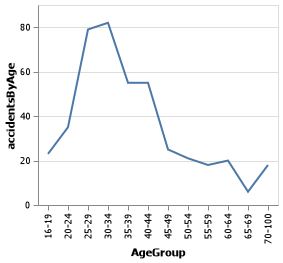

In [51]:
#Calculate the relative risk of which geneder is more exposed to accidents
finalRoadData[!, :AgeGroup] = Vector{Union{String, Nothing}}(nothing, size(finalRoadData, 1))

map(eachrow(finalRoadData)) do r

    if r.Age in 16:19  
       r.AgeGroup = "16-19"

    elseif r.Age in 20:24 
           r.AgeGroup = "20-24"

    elseif r.Age in 25:29 
           r.AgeGroup = "25-29"

    elseif r.Age in 30:34 
           r.AgeGroup = "30-34"

    elseif r.Age in 35:39 
           r.AgeGroup = "35-39"

    elseif r.Age in 40:44 
           r.AgeGroup = "40-44"

    elseif r.Age in 45:49 
           r.AgeGroup = "45-49"

    elseif r.Age in 50:54 
           r.AgeGroup = "50-54"

    elseif r.Age in 55:59 
           r.AgeGroup = "55-59"

    elseif r.Age in 60:64 
           r.AgeGroup = "60-64"

    elseif r.Age in 65:69 
           r.AgeGroup = "65-69"

    elseif r.Age in 70:100 
           r.AgeGroup = "70-100"

    else
         r.AgeGroup = "Other"
    end
end

accidentByAge = 
    finalRoadData |>    
    finalRoadData -> combine(groupby(finalRoadData,[:AgeGroup]),:AgeGroup .=> length => :accidentsByAge) 

accidentByAge |>
    @vlplot(
        :line,
        transform=[
            {filter="datum.AgeGroup !=='Other'"}
        ],
        x=:AgeGroup,
        y=:accidentsByAge
    )

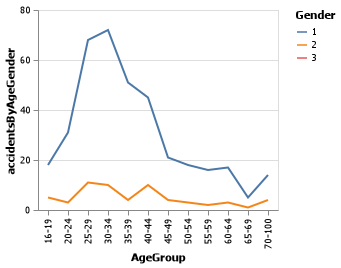

In [52]:
accidentByAgeAndGender = 
    finalRoadData |>    
    finalRoadData -> combine(groupby(finalRoadData,[:AgeGroup,:Gender]),:AgeGroup .=> length => :accidentsByAgeGender) 

accidentByAgeAndGender |>
    @vlplot(
        :line,
        transform=[
            {filter="datum.AgeGroup !=='Other'"}
               ],
        x=:AgeGroup,
        y=:accidentsByAgeGender,
        color=:Gender
    )

# PREDICTIBE ANALYTICS USING REGRESSION  

In [53]:
# a.) Get the data 
regressionData = 
    finalRoadData |>
    finalRoadData -> select(finalRoadData,[:Time,:County,:AgeGroup,:Gender]) |>
    finalRoadData -> transform(finalRoadData,:Time =>  ByRow(hour),renamecols = false) 
    

,Time,County,AgeGroup,Gender
,Int64,String,Union…,Any
1,6,Makueni,25-29,1
2,8,Taita taveta,25-29,1
3,13,Kilifi,Other,1
4,21,Nakuru,65-69,1
5,19,Machakos,Other,1
6,21,Homa bay,Other,1
7,12,Kirinyaga,Other,3
8,13,Nakuru,Other,1
9,19,Nairobi,Other,2


In [54]:
# b.) Create helper functions 

function ConvertData(data::DataFrame,ColName::String)      
    index = findfirst(names(data) .== ColName)
 
    uniqueVar = unique(data[:,index])
    n = Float64.(collect(1:length(uniqueVar)))
    dict_info = Dict(map((x,y) -> (x,y),uniqueVar,n))
    data[!,:newCol] = Vector{Union{Int64, Nothing}}(nothing, size(data, 1))

    for (v,service) in enumerate(data[:,index])
            data[v,:newCol]= dict_info[service]
         end

    omitStringCol = select(data,Not(ColName))
    rename!(omitStringCol,:newCol => ColName)
    
    return omitStringCol,dict_info
end


function splitdf(df, pct)
    @assert 0 <= pct <= 1
    ids = collect(axes(df, 1))
    shuffle!(ids)
    sel = ids .<= nrow(df) .* pct
    trainset =   [df, sel, :]
    testset =  [df, .!sel, :]
    return trainset[1],testset[1]
end


splitdf (generic function with 1 method)

In [55]:
# c.) Create and Run the model

regressionDataUp,countyCodeKey =  ConvertData(regressionData,"County")
regressionDataUp2,ageGroupKeys =  ConvertData(regressionDataUp,"AgeGroup")

transform!(regressionDataUp2,names(regressionDataUp2) .=> ByRow(Float64),renamecols=false)
train,test =  splitdf(regressionDataUp2, 0.7)

ols = lm(@formula(Gender ~ Time + AgeGroup + County), train)
ols

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Gender ~ 1 + Time + AgeGroup + County

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)     Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)   1.2207      0.0412171   29.62    <1e-99   1.13982      1.30157
Time         -0.00228069  0.0021524   -1.06    0.2896  -0.00650412   0.00194274
AgeGroup     -0.00658254  0.00437412  -1.50    0.1327  -0.0151654    0.00200033
County        0.00139395  0.00116844   1.19    0.2331  -0.000898762  0.00368666
───────────────────────────────────────────────────────────────────────────────

In [56]:
# d) Try Generalized linear models

glm = fit(GeneralizedLinearModel, @formula(Gender ~ County+Time+AgeGroup), train, NegativeBinomial(2.0), LogLink())
 
dof(glm)
deviance(glm)
aic(glm)
bic(glm)
coef(glm)[1:4]
glm

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, NegativeBinomial{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Gender ~ 1 + County + Time + AgeGroup

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error      z  Pr(>|z|)     Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)   0.199752    0.0345802     5.78    <1e-08   0.131976     0.267528
County        0.00114688  0.000978823   1.17    0.2413  -0.000771575  0.00306534
Time         -0.00190286  0.0018071    -1.05    0.2923  -0.00544472   0.00163899
AgeGroup     -0.00556979  0.00370862   -1.50    0.1331  -0.0128385    0.00169896
────────────────────────────────────────────────────────────────────────────────

# Data To FSharp For SSA to predict the time series

In [24]:
# toTimeSeriesData = 
#      finalRoadData|>
#      finalRoadData -> combine(groupby(finalRoadData,[:Date]),:Date .=> length => :noOfAccidents) 

# toTimeSeriesData[!,:noOfAccidents] = Float64.(toTimeSeriesData[:,:noOfAccidents])

# CSV.write("D://Projects//Machine Learning Exploration//Analytics and MachineLearning//toTimeSeriesData.csv",toTimeSeriesData)

UndefVarError: UndefVarError: `finalRoadData` not defined